In [1]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
import numpy as np
# Loading your IBM Q account(s)
provider = IBMQ.load_account()


/opt/conda/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


### Task 2
The bit-flip code and the sign-flip code (you can find a description of both here) are two very simple circuits able to detect and fix the bit-flip and the sign-flip errors, respectively. 

1) Build the following simple circuit to prepare the Bell state $\frac{|00\rangle + |11\rangle}{\sqrt{2}}$ 

2)Now add, right before the CNOT gate and for each of the two qubits, an arbitrary “error gate”. By error gate we mean that with a certain probability (that you can decide but must be non-zero for all the choices) you have a 1 qubit unitary which can be either the identity, or the X gate (bit-flip error) or the Z gate (sign-flip error).

3)Encode each of the two qubits with a sign-flip or a bit-flip code, in such a way that all the possible choices for the error gates described in 2), occurring on the logical qubits, can be detected and fixed. Motivate your choice. This is the most non-trivial part of the problem, so do it with a lot of care!

4)Test your solution by making many measurements over the final state and testing that the results are in line with the expectations.


## Part 1

#### Circuit to prepare the Bell State $\frac{|00\rangle + |11\rangle}{\sqrt{2}}$

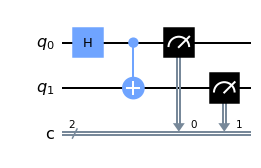

In [2]:
bell00 = QuantumCircuit(2,2)
bell00.h(0)
bell00.cnot(0,1)
bell00.measure([0,1], [0,1])
bell00.draw('mpl')

#### Measuring Bell State $\frac{|00\rangle + |11\rangle}{\sqrt{2}}$
#### Desired output after measurement is either bit string '00' or '11'

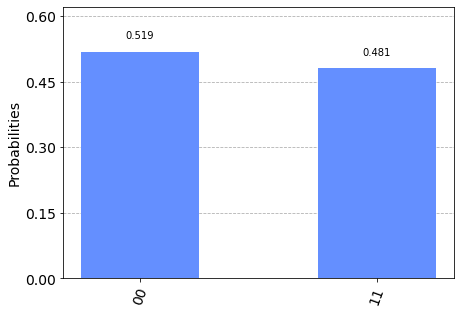

In [3]:
simulator = Aer.get_backend('qasm_simulator')
results = execute(bell00, simulator, shot = 1024).result()
counts = results.get_counts(bell00)
plot_histogram(counts)

#### Funciton to add error gates ( I(none), X (bit-flip), Z(phase-flip)) to a circuit with equal probability 

In [4]:
def addRandomErrorGate(circuit, target_qbit, seed):
    np.random.seed(seed)
    random1 = np.random.rand()
    if random1 < 0.33:
        circuit.i(target_qbit)
    elif random1 < 0.66:
        circuit.x(target_qbit)
    else:
        circuit.z(target_qbit)
    return circuit

### Function to create circuit to add and correct error and measurements according to inputs
1) $\text{correct = True}$:- A circuit with error correction circuit

2) $\text{correct = False}$:- A circuit without error correction circuit

3) $\text{measure = True}$:- Adds classical bit to the circuit to store measurements of qubits

4) seed1 and seed2 are to control the randomness of error. Changing seed1 and seed2 will change the error.
    

In [6]:
def createBellErrorCircuit(correct = False ,measure = False, seed1= 10, seed2 = 18):
    #For circuit without error correction
    if not correct: 
        if measure:
            bell00_Error = QuantumCircuit(2,2)
        else:
            bell00_Error = QuantumCircuit(2)
            
        bell00_Error.h(0)
        bell00_Error.barrier()
        
        # Adding a random error gate
        bell00_Error = addRandomErrorGate(bell00_Error, 0, seed1)
        bell00_Error = addRandomErrorGate(bell00_Error, 1, seed2)
        #gate added
        
        bell00_Error.barrier()
        bell00_Error.cnot(0,1)
        return bell00_Error
    
    #For circuit with error correction
    else:
        if measure:
            bell00_EC = QuantumCircuit(6,2)
        else:
            bell00_EC = QuantumCircuit(6)
        bell00_EC.h(0)
        bell00_EC.barrier()

        # Adding a random error gate
        bell00_EC = addRandomErrorGate(bell00_EC, 0, seed1)
        bell00_EC = addRandomErrorGate(bell00_EC, 3, seed2)
        #gate added

        bell00_EC.barrier()
        
        #Z gate (phase-flip) error correction
        bell00_EC.h(0)
        bell00_EC.cnot(0,1)
        bell00_EC.cnot(0,2)
        bell00_EC.ccx(2,1,0)
        bell00_EC.h(0)
        # Phase flip error corrected


        #X-gate (bit-flip) error correction
        bell00_EC.cnot(3,4)
        bell00_EC.cnot(3,5)
        bell00_EC.ccx(5,4,3)
        bell00_EC.barrier()
        # Bit flip error corrected

        bell00_EC.cnot(0,3)
        return bell00_EC

## Part 2

In [7]:
# set seed1 and seed2 to change gates when circuit is drawn
seed1 = 10
seed2 = 18

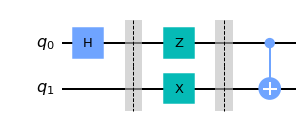

In [8]:
bell = createBellErrorCircuit(correct = False, measure = False, seed1 = seed1, seed2 = seed2)
bell.draw('mpl')

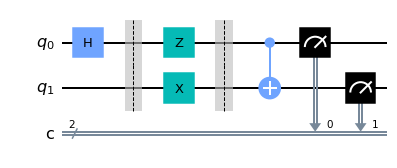

In [9]:
bellError = createBellErrorCircuit(correct = False ,measure = True, seed1 = seed1, seed2 = seed2)
bellError.measure([0,1], [0,1])
bellError.draw('mpl')

We can observe:
1) Only the Z gate error (phase-flip) affects qubit 0. I and X gate have no effect whatsoever.

State of qubit 0 after introducing a random gate error

$$
\text{No error (I gate):} \hspace{7.5 pt}
I\Big(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\Big) = \frac{|0\rangle + |1\rangle}{\sqrt{2}}
$$

$$
 \text{Bit flip error (X gate):} \hspace{7.5 pt}
X \Big(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\Big) = \frac{|0\rangle + |1\rangle}{\sqrt{2}}
$$

$$
\text{Phase flip error (Z gate):} \hspace{7.5 pt}
   Z\Big(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\Big) = \frac{|0\rangle - |1\rangle}{\sqrt{2}}
$$

2) Only the X gate error (phase-flip) affects qubit 1. I and Z gate have no effect whatsoever.

State of qubit 1 after introducing a random gate error
$$
\text{No error (I gate):} \hspace{7.5 pt}
I|0\rangle = |0\rangle
$$

$$
\text{Bit flip error (X gate):} \hspace{7.5 pt}
X |0\rangle = |1\rangle
$$

$$
\text{Phase flip error (Z gate):} \hspace{7.5 pt}
   Z|0\rangle = -|0\rangle \equiv |0\rangle
$$

#### We need to fix Z gate error for qubit 1 and X gate error for qubit 2.


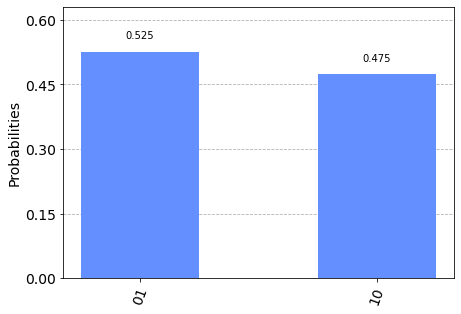

In [10]:
simulator = Aer.get_backend('qasm_simulator')
results = execute(bellError, simulator, shot = 1024).result()
counts = results.get_counts(bellError)
plot_histogram(counts)

In [11]:
#to set number of times to do measurements
numOfMeasurements = 20

In [13]:
# The measurements are done on random gate combinations by randomly generating seeds
correct = 0 
incorrect = 0
for i in range(numOfMeasurements):
    bellErrorCheck = createBellErrorCircuit(correct = False ,measure = True, seed1 = np.random.randint(100000), seed2 = np.random.randint(100000))
    bellErrorCheck.measure([0,1], [0,1])
    simulator = Aer.get_backend('qasm_simulator')
    results = execute(bellErrorCheck, simulator, shot = 1024).result()
    counts = results.get_counts(bellErrorCheck)
    if list(counts.keys()) != ['00', '11']:
        incorrect += 1
    else:
        correct += 1
print('Number of correct measurements: ', correct)
print('Number of incorrect measurements: ', incorrect)

Number of correct measurements:  14
Number of incorrect measurements:  6


## Part 3

## Qubit 0 phase flip error correction
We are using 2 ancilla qubits to correct qubit 0 error
#### State after introducing Z gate error
$$
Z |+\rangle = |-\rangle 
$$
### Error correction
#### After Hadamard
$$
H |-\rangle |00\rangle = |1\rangle |00\rangle
$$
#### Applying CNOT (control qubit is 0, target qubit is 1)
$$
CNOT |1\rangle |00\rangle = |1\rangle |10\rangle
$$
#### Applying CNOT (control qubit is 0, target qubit is 2)
$$
CNOT |1\rangle |10\rangle = |1\rangle |11\rangle
$$
#### Applying CCNOT (control qubits are 1 and 2, target qubit is 0)
$$
CCNOT |1\rangle |11\rangle = |0\rangle |11\rangle
$$
#### Applying Hadamard to qubit 0 
$$
H |0\rangle |11\rangle = |+\rangle |11\rangle
$$
### The phase flip error was corrected


## Qubit 3 bit flip error correction
We are using 2 ancilla qubits to correct qubit 3 error
#### State after introducing Z gate error
$$
X |0\rangle = |1\rangle 
$$
### Error correction
#### Applying CNOT (control qubit is 0, target qubit is 1)
$$
CNOT |1\rangle |00\rangle = |1\rangle |10\rangle
$$
#### Applying CNOT (control qubit is 0, target qubit is 2)
$$
CNOT |1\rangle |10\rangle = |1\rangle |11\rangle
$$
#### Applying CCNOT (control qubits are 1 and 2, target qubit is 0)
$$
CCNOT |1\rangle |11\rangle = |0\rangle |11\rangle
$$
### The bit flip error was corrected


#### Qubit 0 is the first qubit of Bell State   $|\phi ^{+}\rangle$
#### Qubit 3 is the second qubit of Bell State   $|\phi ^{+}\rangle$

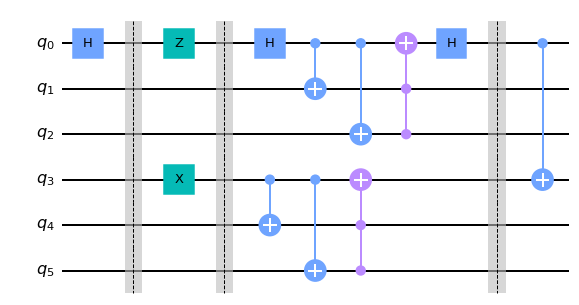

In [15]:
circ1 = createBellErrorCircuit(correct = True ,measure = False, seed1 = seed1, seed2 = seed2)
circ1.draw('mpl')

## Part 4

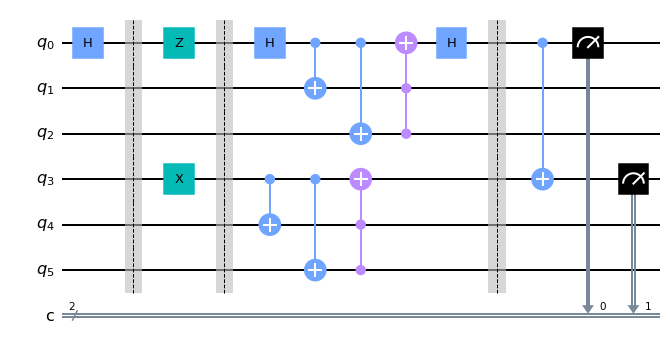

In [16]:
bellM = createBellErrorCircuit(correct = True ,measure = True, seed1 = seed1, seed2 = seed2)
bellM.measure([0,3], [0,1])
bellM.draw('mpl')

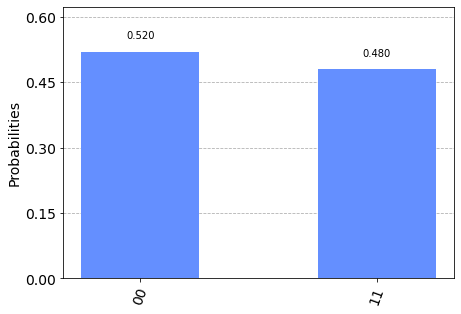

In [17]:
simulator = Aer.get_backend('qasm_simulator')
results = execute(bellM, simulator, shot = 1024).result()
counts = results.get_counts(bellM)
plot_histogram(counts)

In [18]:
correct = 0 
incorrect = 0
for i in range(numOfMeasurements):
    bellCheck = createBellErrorCircuit(correct = True ,measure = True, seed1 = np.random.randint(1000), seed2 = np.random.randint(1000))
    bellCheck.measure([0,3], [0,1])
    simulator = Aer.get_backend('qasm_simulator')
    results = execute(bellCheck, simulator, shot = 1024).result()
    counts = results.get_counts(bellCheck)
    if list(counts.keys()) != ['00', '11']:
        incorrect += 1
    else:
        correct += 1
print('Number of correct measurements: ', correct)
print('Number of incorrect measurements: ', incorrect)

Number of correct measurements:  20
Number of incorrect measurements:  0
